# Project: Walmart Recruiting - Store Sales Forecasting

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#ml">Time Series Forecast</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> These Datasets contain historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, The task is predicting the department-wide sales for each store.In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition in [Kaggle](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data) is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data

> stores.csv

This file contains anonymized information about the 45 stores, indicating the type and size of store.

> train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

| Column name   | Desc         |
|:------------- |:-------------| 
| Store | the store number    |
|Dept| the department number|
|Date|the week|
|Weekly_Sales | sales for the given department in the given store|
|IsHoliday | whether the week is a special holiday week|

>test.csv

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

> features.csv

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

| Column name   | Desc         |
|:------------- |:-------------| 
| Store | - the store number    |
|Date|- the week|
|Temperature|- average temperature in the region|
|Fuel_Price|- cost of fuel in the region|
|MarkDown1-5 |- anonymized data related to promotional markdowns that Walmart is running| 
|CPI |- the consumer price index|
|Unemployment|- the unemployment rate|
|IsHoliday  |- whether the week is a special holiday week|
 
 
- Note: MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pmdarima as pm
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = [14, 4]

%matplotlib inline

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [3]:
import warnings
warnings.simplefilter(action='ignore')

> Load all datasets 

In [16]:
df_store    = pd.read_csv('./time_series/stores.csv')
df_features = pd.read_csv('./time_series/features.csv')
df_train    = pd.read_csv('./time_series/train.csv')
df_test     = pd.read_csv('./time_series/test.csv')

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [21]:
print(df_store.shape)
print(df_features.shape)
print(df_train.shape)
print(df_test.shape)

(45, 3)
(8190, 12)
(421570, 5)
(115064, 4)


In [23]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [24]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [27]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [28]:
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


> Need to Merge df_features with df_store and combine all with train and test df

In [17]:
#Merging df_store with features
df_feat_store = df_features.merge(df_store, how='left', on='Store')
df_feat_store.head(3)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315


In [30]:
#test shape
df_feat_store.shape

(8190, 14)

In [18]:
#make one dataset for train and test
df_all_train = df_train.merge(df_feat_store, how='left', on=['Store', 'Date','IsHoliday'])
df_all_test  = df_test.merge(df_feat_store, how='left', on=['Store', 'Date','IsHoliday'])


In [33]:
df_all_train.shape

(421570, 16)

In [34]:
df_all_test.shape

(115064, 15)

In [35]:
df_all_train.head(1)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.5,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [6]:
df_all_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [7]:
df_all_train.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

> All Null values are in the Markdown columns

In [8]:
df_all_train.duplicated().sum()

0

In [9]:
df_all_train.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


### The structure of your dataset?

> Train Data set contains 421570 observations and 16 columns 13 numerical, 1 bool, 1 date_time, one string (Type of the store)
### The main feature(s) of interest in your dataset?

> Date, IsHoliday(seasonal Component), weekly sales



### Data Cleaning (Replace this with more specific notes!)

- Change Date Column into DateTime 
- Fill all null values with zero

In [19]:
#change Date column into Datetime using pandas to_datetime in train and test datasets
df_all_train['Date'] = pd.to_datetime(df_all_train['Date'])
df_all_test['Date']  = pd.to_datetime(df_all_test['Date'])

In [20]:
# setting date as index
df_all_train.set_index('Date', inplace=True)
df_all_test.set_index('Date', inplace=True)

In [49]:
df_all_train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2010-02-12,1,1,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2010-02-19,1,1,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
2010-02-26,1,1,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
2010-03-05,1,1,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [53]:
print('Week:', df_all_train.index.week, '\n')

Week: Int64Index([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
            ...
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
           dtype='int64', name='Date', length=421570) 



<ipython-input-53-76fadd16ef4f>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  print('Week:', df_all_train.index.week, '\n')


In [21]:
#Fill all null values with zero
df_all_train= df_all_train.fillna(0)
df_all_test = df_all_test.fillna(0)

In [10]:
df_all_test.isnull().sum().any()

False

In [11]:
df_all_train.isnull().sum().any()

False

<a id='eda'></a>
## Exploratory Data Analysis



### Research Question 1 (Replace this header name!)

- Which Dept has the highest weekly sales?
- Which store type has the highest weekly sales?
- Are there Trends or seasonality in the time series?

##  Exploration


In [146]:
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,1,0,0
2010-02-12,1,1,46039.49,0,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315,1,0,0
2010-02-19,1,1,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315,1,0,0
2010-02-26,1,1,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,151315,1,0,0
2010-03-05,1,1,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,151315,1,0,0


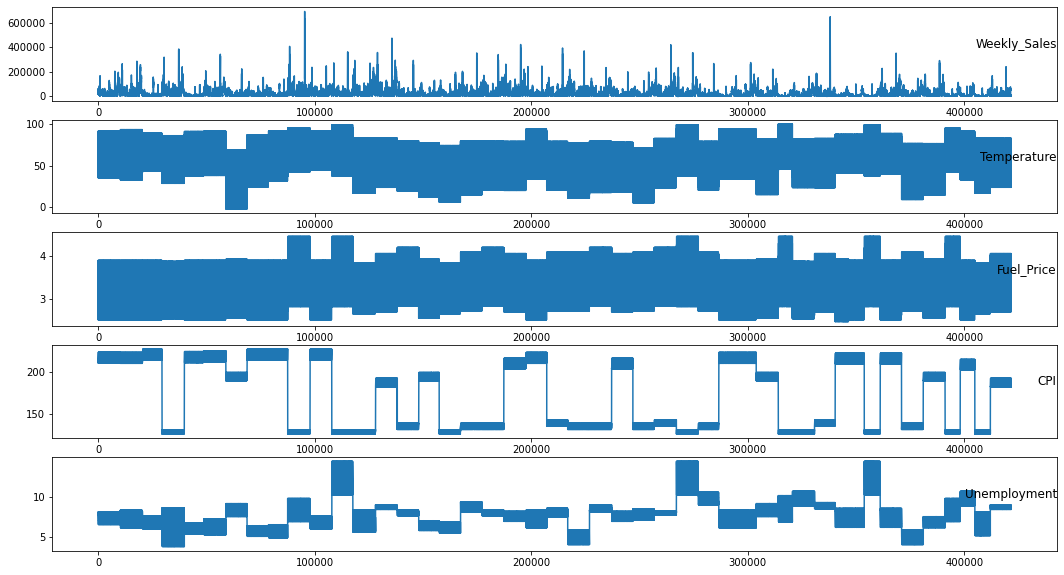

In [152]:
#plotting several Univariate variables
values = df_all_train.values
# specify columns to plot
groups = [2, 4, 5,11,12]
i = 1
# plot each column
plt.figure(figsize=(18,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df_all_train.columns[group], y=0.5, loc='right')
    i += 1
plt.show()


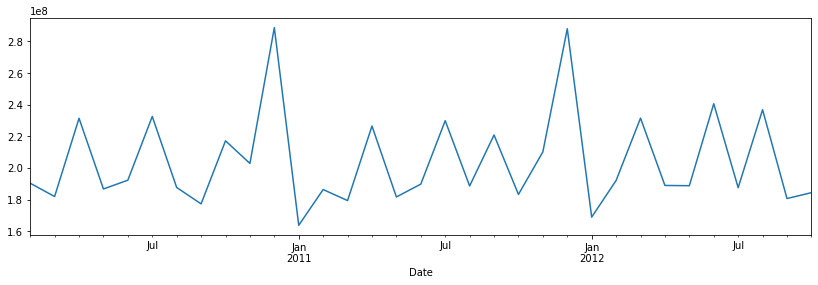

In [10]:
#plotting Monthly Sales
df_all_train['Weekly_Sales'].resample('M').sum().plot();

<AxesSubplot:xlabel='Date'>

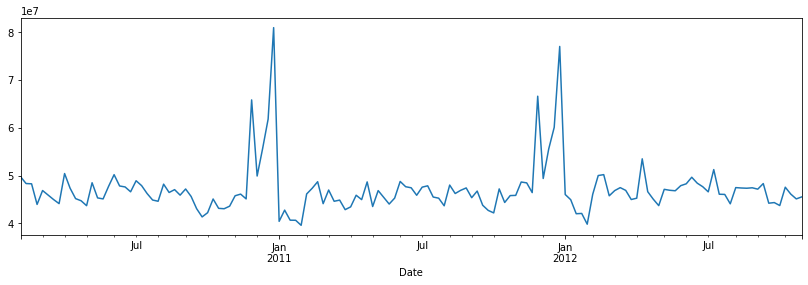

In [63]:
#plotting weekly Sales
df_all_train['Weekly_Sales'].resample('W').sum().plot()

> There's Definitly a surge in sales at the last 2 months of the year because of Thanksgiving and christmas holidays

<AxesSubplot:xlabel='Date'>

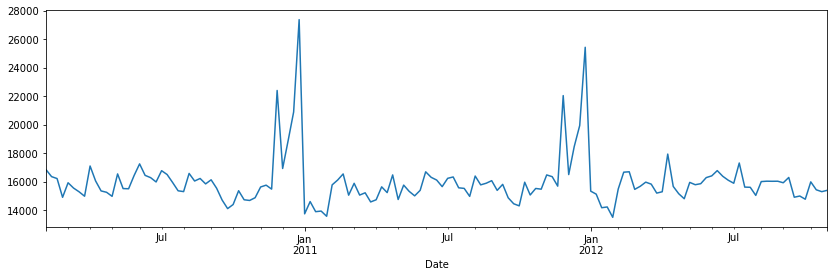

In [64]:
#Plotting average weekly sales
df_all_train['Weekly_Sales'].resample('W').mean().plot()

>The average sales per week are about 16K except for the November and december sales it surges to around 28K

<ipython-input-20-a459185c04a3>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  sb.violinplot(x=df_all_train.index.week, y=df_all_train.Weekly_Sales);


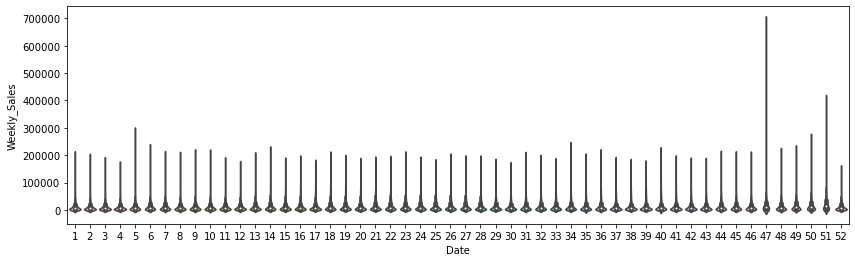

In [20]:
sb.violinplot(x=df_all_train.index.week, y=df_all_train.Weekly_Sales);

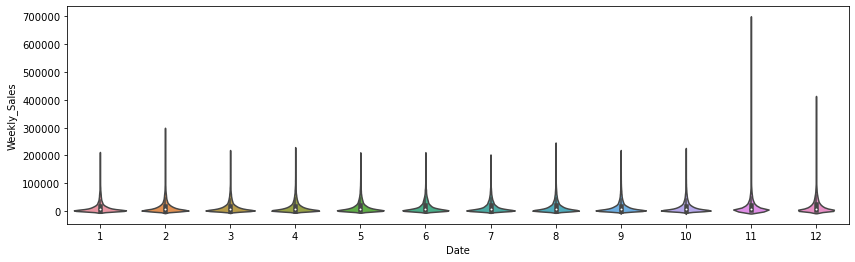

In [68]:
sb.violinplot(x=df_all_train.index.month, y=df_all_train.Weekly_Sales);

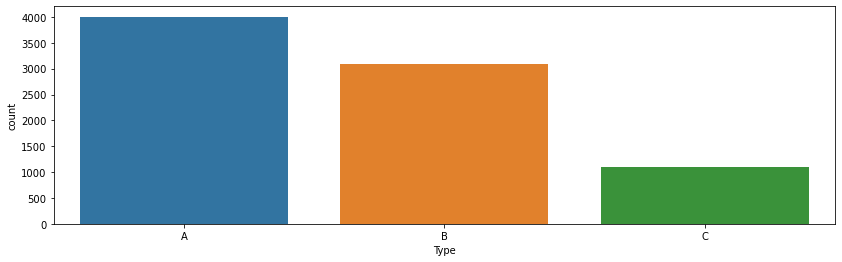

In [65]:
sb.countplot(data=df_feat_store, x= 'Type');

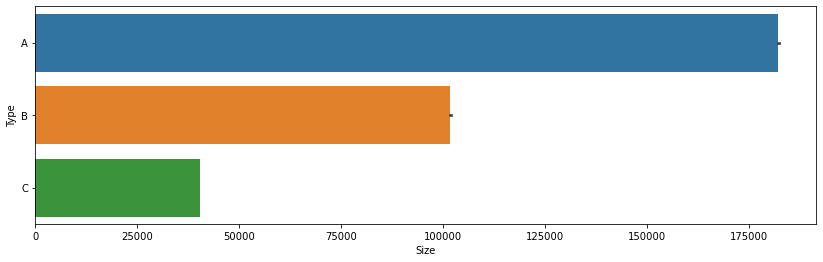

In [64]:
#plotting sizes of the stores
sb.barplot(data=df_all_train, y='Type', x='Size');

> The Most common store type is type A, although there's an ambiguity around the type variable but after searching the internet I suppose the most common is the super store as suggested here by size

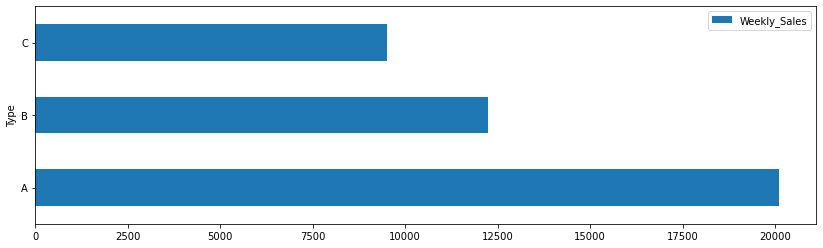

In [70]:
#Which Type of Store has the highest Weekly_sales on Average
df_all_train[['Type','Weekly_Sales']].groupby('Type').mean().plot(kind ='barh');

> Also Store A has the highest weekly sales on average

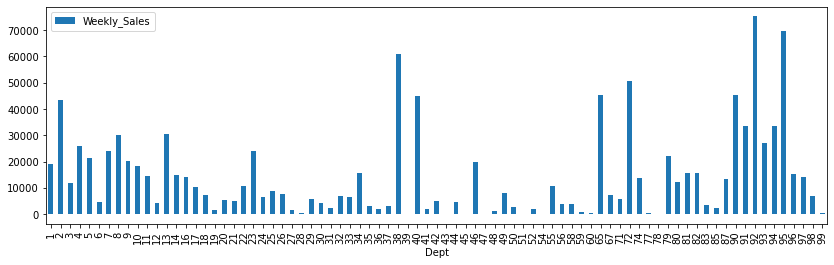

In [72]:
#Which Dept has the highest Sales on Average
df_all_train[['Dept','Weekly_Sales']].groupby('Dept').mean().plot(kind ='bar');

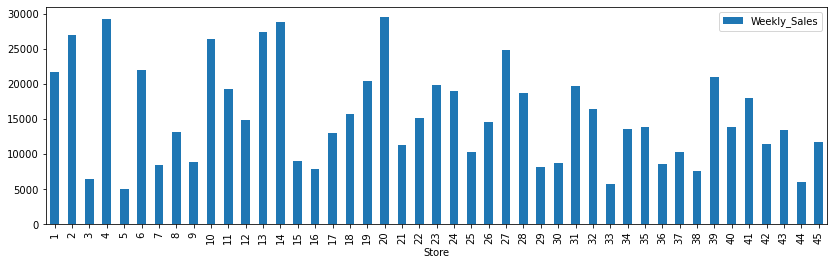

In [73]:
#Which Store has the highest Sales on average
df_all_train[['Store','Weekly_Sales']].groupby('Store').mean().plot(kind ='bar');

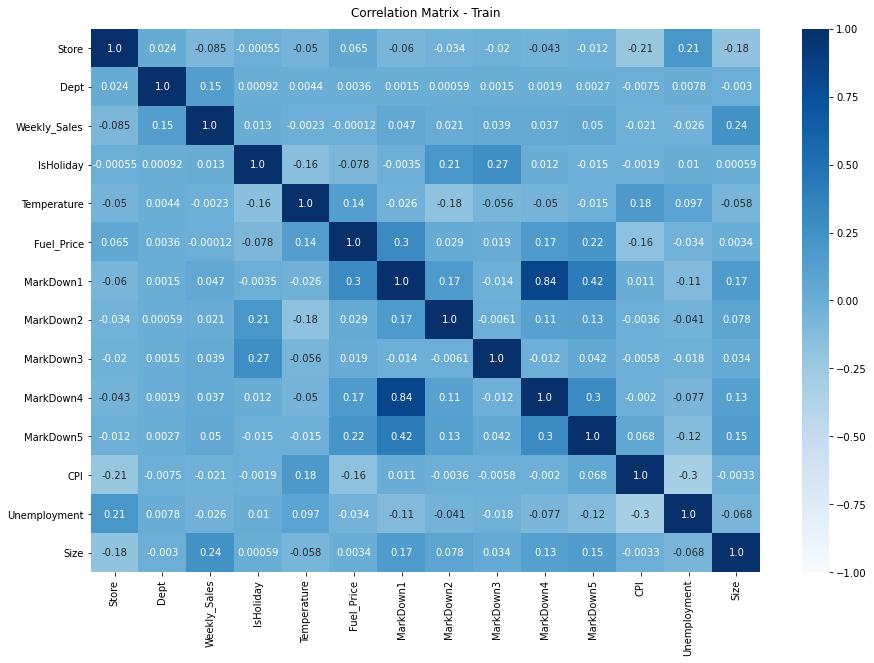

In [85]:
#plotting a heatmap for all features
plt.figure(figsize=(15, 10))
heatmap = sb.heatmap(df_all_train.corr(), vmin=-1, vmax=1, annot=True, fmt=".2", cmap="Blues",
                     annot_kws={"fontsize":10})
heatmap.set_title('Correlation Matrix - Train', fontdict={'fontsize':12}, pad=12);

<a id='ml'></a>
## Time Series Forecast

#### Test for Stationarity

In [29]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 2)
    
    acf  = plt.subplot2grid(layout, (0, 0))
    pacf = plt.subplot2grid(layout, (0, 1))
    
    
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sb.despine()
    plt.tight_layout()

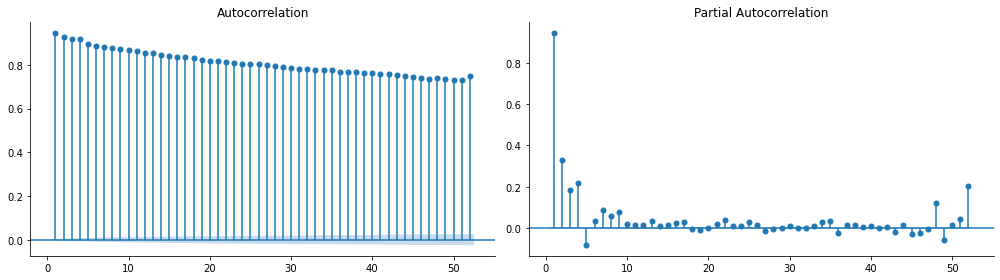

In [30]:
# helper plot for monthly temps
plots(df_all_train.Weekly_Sales, lags=52);
# open Duke guide for visual
# we note a 52-period cycle (Weekly) with suspension bridge design

In [15]:
#Failure to launch - Sarima models are not optimized for medium or Large datsets 
stepwise_model = pm.auto_arima(df_all_train.Weekly_Sales, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic


MemoryError: Unable to allocate 2.12 GiB for an array with shape (26, 26, 421571) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 982, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
MemoryError: Unable to allocate 2.12 GiB for an array with shape (26, 26, 421571) and data type float64


AttributeError: Memoryview is not initialized

In [32]:
train.reset_index()

,Date,Weekly_Sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
...,...,...
421565,2012-09-28,508.37
421566,2012-10-05,628.10
421567,2012-10-12,1061.02
421568,2012-10-19,760.01


In [35]:
train.rename(columns={'Weekly_Sales':'y'},inplace=True)

In [37]:
train['ds'] = train.index

In [39]:
m = Prophet()
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [49]:
# forecast 40 weeks from the last week of the train data into future
# prophet requires a blank dataframe to input predictions
# will also provide blank set for dates within dataset to allow for fit
future = m.make_future_dataframe(periods=40, freq='W')
print(future.head())
print(future.tail())

          ds
0 2010-02-05
1 2010-02-12
2 2010-02-19
3 2010-02-26
4 2010-03-05
            ds
178 2013-06-30
179 2013-07-07
180 2013-07-14
181 2013-07-21
182 2013-07-28


In [50]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
178,2013-06-30,16092.175043,-10748.233787,43381.743753
179,2013-07-07,15763.469989,-14909.381149,42373.006736
180,2013-07-14,15466.839264,-13112.929642,45243.362336
181,2013-07-21,15366.394860,-13707.899698,43740.586243
182,2013-07-28,15389.805825,-14379.006418,43029.282155


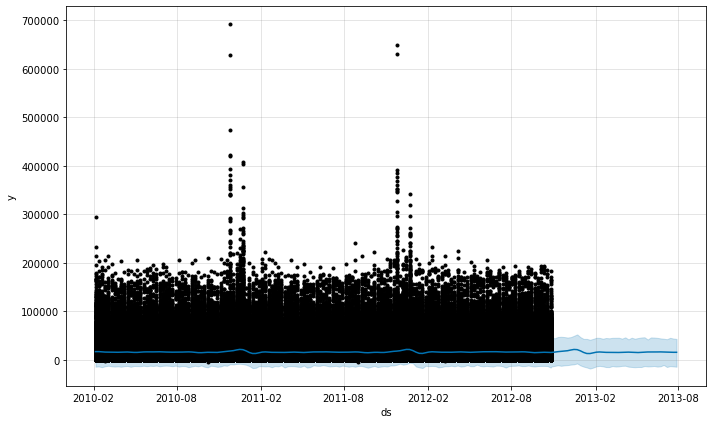

In [51]:
# plot forecast
m.plot(forecast);

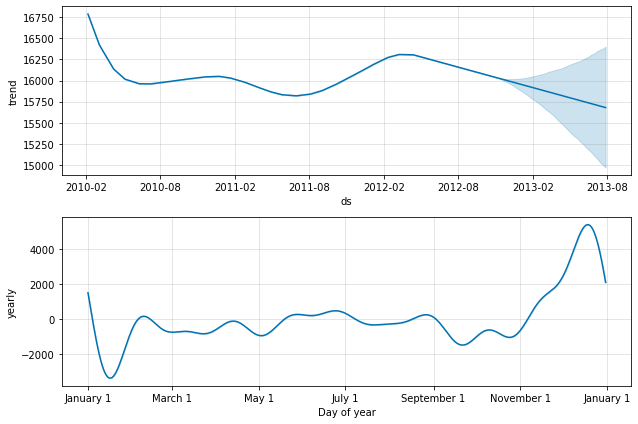

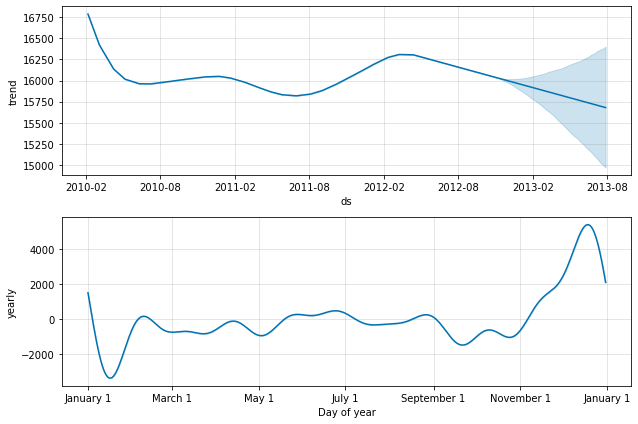

In [52]:
# plot individual components of forecast: trend, weekly/yearly seasonality
m.plot_components(forecast)

In [55]:
# add holidays 
#Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
#Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
#Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
#Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13
other_holidays = pd.DataFrame({
  'holiday': 'other_holidays',
  'ds': pd.to_datetime(['2010-09-10', '2011-09-09', '2013-09-07',
                        '2010-11-26', '2011-11-25', '2012-11-23','2013-11-29',
                        '2010-12-31', '2011-12-30', '2012-12-28','2013-12-27']),
  'lower_window': 0, # these help us specify spillover into previous and future days which will be treated as own holidays
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((other_holidays, superbowls))

In [57]:
# fit and predict with holidays 
m = Prophet(holidays=holidays)
forecast = m.fit(train).predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [61]:
# we can see the effects of various 'holidays' on Weekly_sales
forecast[(forecast['other_holidays'] + forecast['superbowl']).abs() > 0][
        ['ds', 'other_holidays', 'superbowl']][-10:]

,ds,other_holidays,superbowl
1,2010-02-12,0.000000,-56.958032
31,2010-09-10,374.528296,0.000000
42,2010-11-26,374.528296,0.000000
47,2010-12-31,374.528296,0.000000
53,2011-02-11,0.000000,-56.958032
83,2011-09-09,374.528296,0.000000
94,2011-11-25,374.528296,0.000000
99,2011-12-30,374.528296,0.000000
105,2012-02-10,0.000000,-56.958032


In [86]:
# Manually Evaluating FBP
# create test dataset, remove last 12 months
train_ = train.drop(train.index[-180:])
print(train.tail())


                  y         ds
Date                          
2012-09-28   508.37 2012-09-28
2012-10-05   628.10 2012-10-05
2012-10-12  1061.02 2012-10-12
2012-10-19   760.01 2012-10-19
2012-10-26  1076.80 2012-10-26


In [87]:
# calculate MAE between expected and predicted values 
from sklearn.metrics import mean_absolute_error
y_true = train['y'][-180:].values
y_pred = forecast['yhat'][-180:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 14099.713


#### Applying LSTMs 

In [11]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [77]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [81]:
train = df_all_train.copy()

In [83]:
train = pd.get_dummies(train)
train['IsHoliday'] = train['IsHoliday'].apply(lambda x : 1 if x =='True' else 0)

In [84]:
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,1,0,0
2010-02-12,1,1,46039.49,0,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315,1,0,0
2010-02-19,1,1,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315,1,0,0
2010-02-26,1,1,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,151315,1,0,0
2010-03-05,1,1,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,151315,1,0,0


In [125]:
train.shape

(421570, 17)

In [85]:
values = train.values

# integer encode direction
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,5,6,7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var3(t-1)  var4(t-1)  var5(t-1)  var13(t-1)  var14(t-1)  var15(t-1)  \
1   0.042851        0.0   0.434149    0.405118    0.630267         1.0   
2   0.073097        0.0   0.396967    0.405118    0.630267         1.0   
3   0.066732        0.0   0.410861    0.405118    0.630267         1.0   
4   0.034942        0.0   0.476419    0.405118    0.630267         1.0   
5   0.038415        0.0   0.475147    0.405118    0.630267         1.0   

   var16(t-1)  var17(t-1)  var1(t)  var2(t)  ...   var8(t)   var9(t)  \
1         0.0         0.0      0.0      0.0  ...  0.002536  0.000205   
2         0.0         0.0      0.0      0.0  ...  0.002536  0.000205   
3         0.0         0.0      0.0      0.0  ...  0.002536  0.000205   
4         0.0         0.0      0.0      0.0  ...  0.002536  0.000205   
5         0.0         0.0      0.0      0.0  ...  0.002536  0.000205   

   var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  var16(t)  \
1       0.0       0.0  0.841941  0.405118  0.63

In [134]:
values = reframed.values

##test = values[n_train_time:n_test_time, :]
# split into input and outputs
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(values[:,1:], values[:,0], random_state = 123, shuffle = False)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(316176, 1, 24) (316176,) (105393, 1, 24) (105393,)


In [160]:
#Simple model architecture 
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [161]:
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=70, validation_data=(test_X, test_y), shuffle=False)

Epoch 1/10
4517/4517 [==============================] - 19s 4ms/step - loss: 7.4308e-04 - val_loss: 7.7133e-04
Epoch 2/10
4517/4517 [==============================] - 14s 3ms/step - loss: 2.9113e-04 - val_loss: 6.2982e-04
Epoch 3/10
4517/4517 [==============================] - 12s 3ms/step - loss: 1.4890e-04 - val_loss: 1.3004e-04
Epoch 4/10
4517/4517 [==============================] - 11s 3ms/step - loss: 1.2009e-04 - val_loss: 1.0546e-04
Epoch 5/10
4517/4517 [==============================] - 12s 3ms/step - loss: 1.1755e-04 - val_loss: 8.3084e-05
Epoch 6/10
4517/4517 [==============================] - 10s 2ms/step - loss: 1.1471e-04 - val_loss: 8.0838e-05
Epoch 7/10
4517/4517 [==============================] - 9s 2ms/step - loss: 1.1271e-04 - val_loss: 8.2913e-05
Epoch 8/10
4517/4517 [==============================] - 9s 2ms/step - loss: 1.1129e-04 - val_loss: 7.9901e-05
Epoch 9/10
4517/4517 [==============================] - 10s 2ms/step - loss: 1.1011e-04 - val_loss: 8.2673e-05
Epo

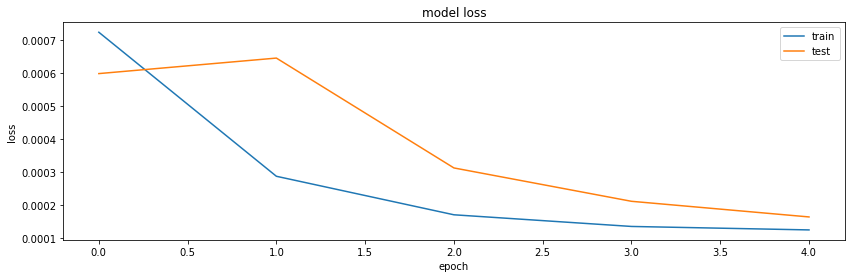

In [159]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [143]:
# model with drop out
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [144]:
history = model.fit(train_X, train_y, epochs=5, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/5
4517/4517 - 12s - loss: 7.2478e-04 - val_loss: 5.9951e-04
Epoch 2/5
4517/4517 - 10s - loss: 2.8845e-04 - val_loss: 6.4650e-04
Epoch 3/5
4517/4517 - 10s - loss: 1.7177e-04 - val_loss: 3.1369e-04
Epoch 4/5
4517/4517 - 10s - loss: 1.3645e-04 - val_loss: 2.1264e-04
Epoch 5/5
4517/4517 - 10s - loss: 1.2595e-04 - val_loss: 1.6526e-04


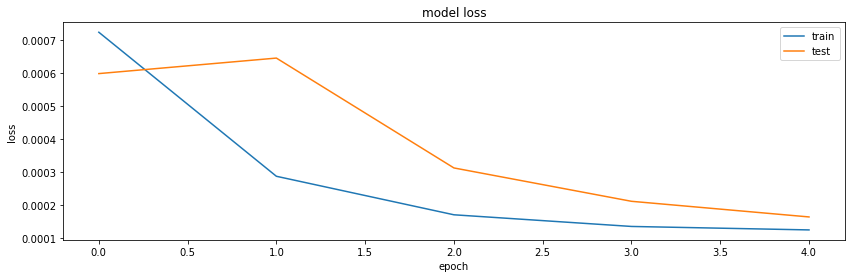

In [145]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [142]:
yhat = model.predict(test_X)

In [107]:
#test_X = test_X.reshape((test_X.shape[0], 24))

inv_yhat = np.concatenate((yhat, test_X[:, 8:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [127]:
 #invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [128]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 118.878


In [132]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               50000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 50,101
Trainable params: 50,101
Non-trainable params: 0
_________________________________________________________________


<a id='conclusions'></a>
## Conclusions

> EDA Findings:
- There's Definitely a surge in sales at the last 2 months of each year because of Thanksgiving and Christmas holidays

- The average sales per week are about 16K except for the November and december sales it surges to around 28K

- The Most common store type is type A, although there's an ambiguity around the type variable but after searching the internet I suppose the most common is the super store as suggested by the plots by size

-  Also Store A has the highest weekly sales on average


> Models Conclusion:
- Using Facebook prophet univariate model didn’t do a good job at predicting 40 weekly sales, also adding features into the model is suggested as a separate layer (adding regressor ) not so helpful when you’re working with multiple features
 - LSTM multivariate model accepts the training and test data set in 3D format, after scaling the data you must reverse the scaling, but it’s fast accurate able to capture complex patterns, and produce less error   
